In [1]:
import sys
sys.path.insert(0, './scripts')
sys.path.insert(1, './')
sys.path.insert(0, './util')

from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from qutip.expect import expect
import numpy as np
from samplers_util import thermal_rejection
import matplotlib.pyplot as plt
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:

import os

#Move the directory back to Duke_Data
#Check if the current directory is Duke_Data
if os.getcwd().split('/')[-1] != 'DUKE_ANALOG_ZNE_DATA':
    #os.chdir('Duke_Data')
    os.chdir('../')
    #print(os.getcwd().split('/')[-1])
    #pass
else:
    pass
print(os.getcwd())
from index import print_index, get_experiment, index_folder
from functions_util import cetina_thermal_exp, cetina_envelope_exp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import numpy as np
import h5py
from fitting_functions_ZNE import linear_ZNE, third_no_first_ZNE


/Users/thomassteckmann/Duke_Analog_ZNE_data


In [3]:
# import all the useful lib in python
from matplotlib import artist as art
%matplotlib inline
import scipy as sp
# import pandas as pd
import pathlib
import os
import datetime as dt
import glob
from IPython.display import clear_output
from numpy.fft import fft, ifft

from h5analysis import *
from qsim_functions import*


#Pairs:
#prefix is 558
#Round 1 (July 11 week data)
names = [(8,9),(9,10),(10,11), (11,12), (12,13), (13,14)]
data_names = ['000558346','000558347','000558348','000558349','000558350','000558352']
data_folder = 'JIJ_PAIRS'
#July 18 data


#Prefix is 563
names = [(4,5),(5,6),(6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(12,13),(13,14),(14,15),(15,16),(16,17),(17,18)]
data_names = [180,161,181,182,183,184,185,186,187,188,189,190,191, 192]
data_folder = 'JIJ_PAIRS_ROUND_2'

full_data_folder_path = './data/' + data_folder + '/'
for name_index in range(len(data_names)):
    name = str(data_names[name_index])
    if '0005638' in name:
        pass
    else:
        name = '000563' + name
        data_names[name_index] = name
        

In [5]:
pair = names[0]
file = h5py.File(full_data_folder_path + data_names[0] + '-RFSoCSequence.h5', 'r')
archive = file['archive']
dataset = file['datasets']
x_vals = dataset['data.rfsoc_pulse_sequence.x_values']
raw_counts = dataset['data.rfsoc_pulse_sequence.raw_counts']
counts = np.asarray(raw_counts)
print(counts.shape)
measurements = np.zeros((2, 150, 30))
for pair_index in range(len(names[0])):
    qubit = names[0][pair_index]
    measurements[pair_index,:,:] = 1 < counts[qubit,:,:]
    #print(measurements)
#Convert the measurements to bitstrings. Convert to string, then append the like indices
counts_bitstrings = np.zeros((150, 30), dtype='<U5')
expectations = np.zeros((150, 30))
for i in range(150):
    for j in range(30):
        expectation = ((measurements[0,i,j]*2-1) - (measurements[1,i,j]*2-1))/2
        bitstring = str(int(measurements[0,i,j])) + str(int(measurements[1,i,j]))
        #print(bitstring)
        counts_bitstrings[i,j] = bitstring
        expectations[i,j] = expectation
#average expectations across the 150 axis:
expectations_avg = np.mean(expectations, axis=0)
#Convert counts_bitstrings to a dictionary of counts
print(counts_bitstrings)
counts_array  = np.zeros((30,), dtype=dict)
for i in range(30):
    counts_array[i] = {}
    for j in range(150):
        if counts_bitstrings[j,i] in counts_array[i]:
            counts_array[i][counts_bitstrings[j,i]] += 1
        else:
            counts_array[i][counts_bitstrings[j,i]] = 1
            
leakage = np.zeros((30,))
for i in range(30):
    if '00' in counts_array[i]:
        leakage[i] = counts_array[i]['00']/150
    if '11' in counts_array[i]:
        leakage[i] += counts_array[i]['11']/150
leakage_conv = np.zeros((30,))
for i in range(30):
    leakage_conv[i] = np.mean(leakage[i:i+3])
#print(counts_array)

(23, 150, 30)
[['10' '10' '01' ... '01' '11' '10']
 ['10' '10' '10' ... '01' '10' '10']
 ['10' '10' '10' ... '10' '00' '01']
 ...
 ['10' '01' '10' ... '01' '01' '10']
 ['10' '11' '11' ... '10' '10' '01']
 ['10' '11' '10' ... '01' '10' '11']]


In [6]:
leakage_matrix = np.zeros((30, len(data_names)))
flopping_matrix = np.zeros((30, len(data_names)))
flopping_std_matrix = np.zeros((30, len(data_names)))
times = None


print(os.getcwd())
for file_id_index in range(len(data_names)):
    file_id = data_names[file_id_index]
    pair = names[file_id_index]
    #pair = names[0]
    file = h5py.File(full_data_folder_path + file_id + '-RFSoCSequence.h5', 'r')
    archive = file['archive']
    dataset = file['datasets']
    x_vals = dataset['data.rfsoc_pulse_sequence.x_values']
    times = np.array(x_vals)
    print(times)
    raw_counts = dataset['data.rfsoc_pulse_sequence.raw_counts']
    counts = np.asarray(raw_counts)
    print(counts.shape)
    measurements = np.zeros((2, 150, 30))
    for pair_index in range(len(pair)):
        qubit = pair[pair_index]
        measurements[pair_index,:,:] = 1 < counts[qubit,:,:]
        #print(measurements)
    #Convert the measurements to bitstrings. Convert to string, then append the like indices
    counts_bitstrings = np.zeros((150, 30), dtype='<U5')
    expectations = np.zeros((150, 30))
    for i in range(150):
        for j in range(30):
            expectation = ((measurements[0,i,j]*2-1) - (measurements[1,i,j]*2-1))/2
            bitstring = str(int(measurements[0,i,j])) + str(int(measurements[1,i,j]))
            #print(bitstring)
            counts_bitstrings[i,j] = bitstring
            expectations[i,j] = expectation
    #average expectations across the 150 axis:
    expectations_avg = np.mean(expectations, axis=0)
    #Convert counts_bitstrings to a dictionary of counts
    print(counts_bitstrings)
    counts_array  = np.zeros((30,), dtype=dict)
    for i in range(30):
        counts_array[i] = {}
        for j in range(150):
            if counts_bitstrings[j,i] in counts_array[i]:
                counts_array[i][counts_bitstrings[j,i]] += 1
            else:
                counts_array[i][counts_bitstrings[j,i]] = 1
                
    leakage = np.zeros((30,))
    for i in range(30):
        if '00' in counts_array[i]:
            leakage[i] = counts_array[i]['00']/150
        if '11' in counts_array[i]:
            leakage[i] += counts_array[i]['11']/150
    leakage_conv = np.zeros((30,))
    for i in range(30):
        leakage_conv[i] = np.mean(leakage[i:i+4])
    leakage_matrix[:,file_id_index] = leakage#leakage_conv
    flopping_matrix[:,file_id_index] = expectations_avg
    flopping_std = np.std(expectations, axis=0)
    flopping_std_matrix[:,file_id_index] = flopping_std
    
#print(counts_array)

/Users/thomassteckmann/Duke_Analog_ZNE_data
[0.         0.08413281 0.16826563 0.25239844 0.33653125 0.42066406
 0.50479688 0.58892969 0.6730625  0.75719531 0.84132812 0.92546094
 1.00959375 1.09372656 1.17785937 1.26199219 1.346125   1.43025781
 1.51439063 1.59852344 1.68265625 1.76678906 1.85092188 1.93505469
 2.0191875  2.10332031 2.18745313 2.27158594 2.35571875 2.43985156]
(23, 150, 30)
[['10' '10' '01' ... '01' '11' '10']
 ['10' '10' '10' ... '01' '10' '10']
 ['10' '10' '10' ... '10' '00' '01']
 ...
 ['10' '01' '10' ... '01' '01' '10']
 ['10' '11' '11' ... '10' '10' '01']
 ['10' '11' '10' ... '01' '10' '11']]
[0.         0.08413281 0.16826563 0.25239844 0.33653125 0.42066406
 0.50479688 0.58892969 0.6730625  0.75719531 0.84132812 0.92546094
 1.00959375 1.09372656 1.17785937 1.26199219 1.346125   1.43025781
 1.51439063 1.59852344 1.68265625 1.76678906 1.85092188 1.93505469
 2.0191875  2.10332031 2.18745313 2.27158594 2.35571875 2.43985156]
(23, 150, 30)
[['10' '10' '00' ... '10' '0

[0.2481161  0.26379865 0.31134655 0.29498179 0.31111749 0.32537153
 0.29784526 0.2458404  0.20528013 0.29528317 0.33242619 0.26699906
 0.27161937 0.35093022]


/var/folders/vf/9t237r796tb0tg2rrtljdd940000gn/T/ipykernel_44979/3706963121.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


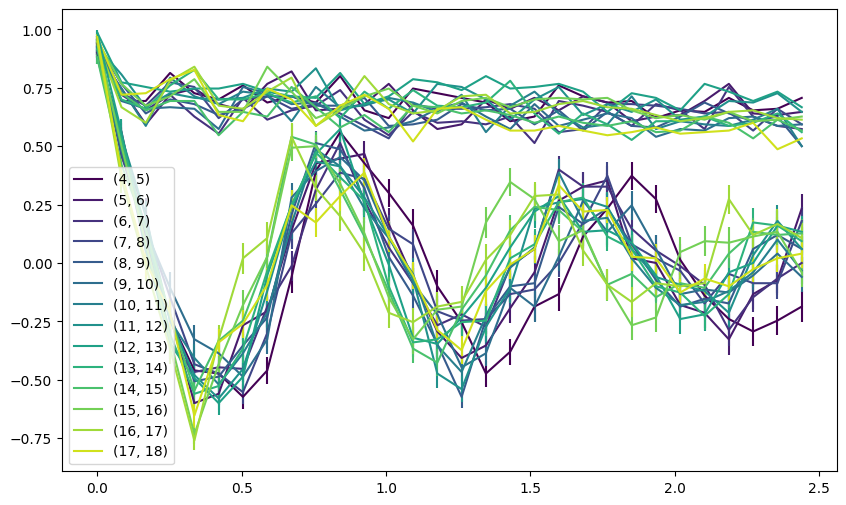

In [16]:
cmap = cm.get_cmap('viridis')
fig = plt.figure()
    
def exp_fit(x, b, c):
    return np.exp(-b*x)*np.cos(2*np.pi*c*x)
gammas = np.zeros((len(data_names),))
for name_index in range(len(data_names)):
    popt, pcov = curve_fit(exp_fit, times, 1-leakage_matrix[:,name_index], p0=[0.05, 1])
    gammas[name_index] = popt[0]
    color = cmap(name_index/len(data_names))
    plt.plot(times, 1-leakage_matrix[:,name_index], label = names[name_index], color=color)
    plt.errorbar(times, flopping_matrix[:,name_index], yerr = flopping_std_matrix[:,name_index]/np.sqrt(150), color=color)
print(gammas)


#make it bigger:
fig.set_size_inches(10, 6)
plt.legend()

In [17]:
#Sort the leakage matrix by average for each pair:
leakage_avg = np.mean(leakage_matrix, axis=0)
sorted_indices = np.argsort(leakage_avg)
leakage_matrix_sorted = np.zeros((30, len(data_names)))
flopping_sorted = np.zeros((30, len(data_names)))
flopping_std_sorted = np.zeros((30, len(data_names)))
for i in range(len(data_names)):
    leakage_matrix_sorted[:,i] = leakage_matrix[:,sorted_indices[i]]
    flopping_sorted[:,i] = flopping_matrix[:,sorted_indices[i]]
    flopping_std_sorted[:,i] = flopping_std_matrix[:,sorted_indices[i]]
print(sorted_indices)
names_sorted = [names[i] for i in sorted_indices]
print(names_sorted)
gammas_sorted = gammas[sorted_indices]
print(gammas_sorted)
#names_sorted = names[sorted_indices]

[ 8  7  0 11  1 12  9  3  6  4  2  5 13 10]
[(12, 13), (11, 12), (4, 5), (15, 16), (5, 6), (16, 17), (13, 14), (7, 8), (10, 11), (8, 9), (6, 7), (9, 10), (17, 18), (14, 15)]
[0.20528013 0.2458404  0.2481161  0.26699906 0.26379865 0.27161937
 0.29528317 0.29498179 0.29784526 0.31111749 0.31134655 0.32537153
 0.35093022 0.33242619]


/var/folders/vf/9t237r796tb0tg2rrtljdd940000gn/T/ipykernel_44979/231513481.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


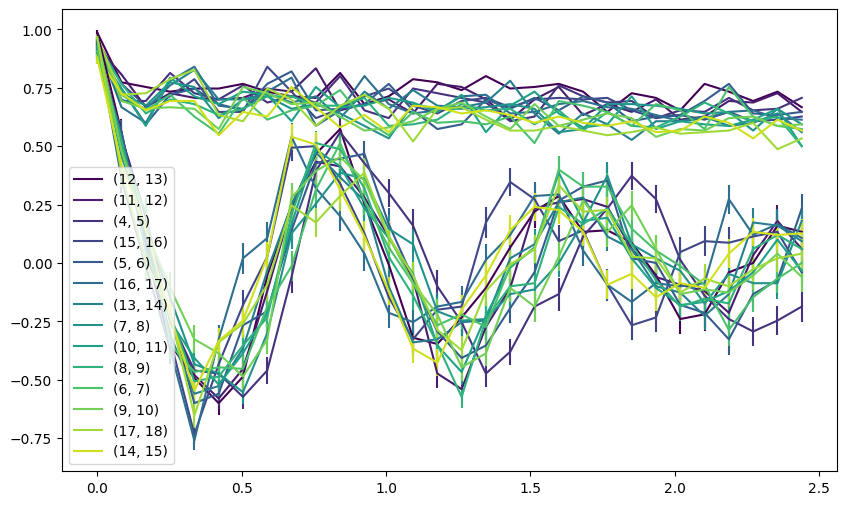

In [9]:
cmap = cm.get_cmap('viridis')
fig = plt.figure()
for name_index in range(len(data_names)):
    color = cmap(name_index/len(data_names))
    plt.plot(times, 1-leakage_matrix_sorted[:,name_index], label = names_sorted[name_index], color=color)
    plt.errorbar(times, flopping_sorted[:,name_index], yerr = flopping_std_sorted[:,name_index]/np.sqrt(150), color=color)
#make it bigger:
fig.set_size_inches(10, 6)
plt.legend()

In [10]:
print(times*1e-3)
print(np.linspace(0, 4, 200) * 1e-3)
integration_times = np.linspace(0, 6e-3, 200)
#integration_times = np.concatenate((times*1e-3, np.linspace(0, 4, 200) * 1e-3))
#integration_times.sort()
#get the index of the x values in the sorted array
#indices = np.searchsorted(integration_times, times*1e-3)
#print(integration_times)
#integration_times = [0.0, 6.280676636120198e-06, 2.0100502512562815e-05, 4.020100502512563e-05, 6.030150753768844e-05, 8.040201005025126e-05, 0.00010050251256281407, 0.00012060301507537688, 0.00013844383184556175, 0.0001407035175879397, 0.00016080402010050252, 0.00018090452261306533, 0.00020100502512562814, 0.00022110552763819098, 0.00024120603015075377, 0.0002613065326633166, 0.0002814070351758794, 0.00028460799164685836, 0.00030150753768844223, 0.00032160804020100504, 0.0003417085427135678, 0.00036180904522613067, 0.0003819095477386935, 0.0004020100502512563, 0.0004020740471208951, 0.0004221105527638191, 0.00044221105527638197, 0.0004623115577889447, 0.00048241206030150754, 0.0005025125628140703, 0.0005226130653266332, 0.0005347118126554842, 0.000542713567839196, 0.0005628140703517588, 0.0005829145728643215, 0.0006030150753768845, 0.0006231155778894473, 0.0006432160804020101, 0.0006633165829145729, 0.0006781706936034394, 0.0006834170854271356, 0.0007035175879396985, 0.0007236180904522613, 0.0007437185929648241, 0.000763819095477387, 0.0007839195979899499, 0.0008040201005025126, 0.000812248110457643, 0.0008241206030150754, 0.0008442211055276382, 0.000864321608040201, 0.0008844221105527639, 0.0009045226130653266, 0.0009246231155778894, 0.0009447236180904523, 0.0009514196781350978, 0.0009648241206030151, 0.0009849246231155779, 0.0010050251256281406, 0.0010251256281407035, 0.0010452261306532664, 0.0010653266331658291, 0.001080687710361139, 0.001085427135678392, 0.001105527638190955, 0.0011256281407035177, 0.0011457286432160806, 0.001165829145728643, 0.001185929648241206, 0.0012046401069455265, 0.001206030150753769, 0.0012261306532663316, 0.0012462311557788945, 0.0012663316582914572, 0.0012864321608040202, 0.001306532663316583, 0.0013266331658291458, 0.0013324843081961252, 0.0013467336683417087, 0.0013668341708542712, 0.0013869346733668341, 0.001407035175879397, 0.0014271356783919597, 0.0014472361809045227, 0.0014673366834170854, 0.0014791388986667405, 0.0014874371859296483, 0.0015075376884422112, 0.001527638190954774, 0.0015477386934673368, 0.0015678391959798998, 0.0015879396984924622, 0.0016080402010050252, 0.001611618460759614, 0.0016281407035175879, 0.0016482412060301508, 0.0016683417085427137, 0.0016884422110552764, 0.0017085427135678393, 0.001728643216080402, 0.001748743718592965, 0.0017495402212475133, 0.0017688442211055279, 0.0017889447236180904, 0.0018090452261306533, 0.001829145728643216, 0.001849246231155779, 0.0018693467336683418, 0.001879029738291957, 0.0018894472361809045, 0.0019095477386934674, 0.0019296482412060301, 0.001949748743718593, 0.0019698492462311558, 0.0019899497487437185, 0.0019937905149126516, 0.002010050251256281, 0.0020301507537688443, 0.002050251256281407, 0.00207035175879397, 0.002090452261306533, 0.002110552763819095, 0.0021306532663316583, 0.002141536709131107, 0.002150753768844221, 0.002170854271356784, 0.002190954773869347, 0.00221105527638191, 0.002231155778894472, 0.0022512562814070354, 0.002271356783919598, 0.0022753135394460505, 0.002291457286432161, 0.002311557788944724, 0.002331658291457286, 0.0023517587939698493, 0.002371859296482412, 0.002391959798994975, 0.002412060301507538, 0.0024269357179865446, 0.0024321608040201005, 0.0024522613065326633, 0.0024723618090452264, 0.002492462311557789, 0.0025125628140703522, 0.0025326633165829145, 0.002552763819095477, 0.0025728643216080403, 0.002574903397023403, 0.002592964824120603, 0.002613065326633166, 0.0026331658291457284, 0.0026532663316582916, 0.0026733668341708543, 0.0026934673366834174, 0.002712524570972042, 0.00271356783919598, 0.0027336683417085424, 0.0027537688442211055, 0.0027738693467336682, 0.0027939698492462314, 0.002814070351758794, 0.0028262886659099267, 0.002834170854271357, 0.0028542713567839195, 0.0028743718592964826, 0.0028944723618090453, 0.0029145728643216085, 0.0029346733668341707, 0.0029547738693467334, 0.0029748743718592966, 0.0029932565782968615, 0.0029949748743718593, 0.0030150753768844224, 0.003035175879396985, 0.003055276381909548, 0.0030753768844221105, 0.0030940954520465597, 0.0030954773869346737, 0.0031155778894472364, 0.0031356783919597995, 0.0031557788944723618, 0.0031758793969849245, 0.0031959798994974876, 0.0032160804020100503, 0.0032361809045226135, 0.00323671585475342, 0.0032562814070351757, 0.003276381909547739, 0.0032964824120603016, 0.0033165829145728647, 0.0033366834170854274, 0.0033514608110299434, 0.00335678391959799, 0.003376884422110553, 0.0033969849246231155, 0.0034170854271356787, 0.0034371859296482414, 0.003457286432160804, 0.0034773869346733668, 0.00349748743718593, 0.003513097267431053, 0.0035175879396984926, 0.0035376884422110557, 0.003557788944723618, 0.0035778894472361807, 0.003597989949748744, 0.0036180904522613066, 0.003631844770782988, 0.0036381909547738697, 0.003658291457286432, 0.003678391959798995, 0.003693575753740523, 0.003698492462311558, 0.003718592964824121, 0.0037386934673366836, 0.0037587939698492463, 0.003769608327829172, 0.003778894472361809, 0.0037989949748743717, 0.003819095477386935, 0.0038391959798994976, 0.0038592964824120603, 0.003879396984924623, 0.003899497487437186, 0.003912766622237867, 0.003919597989949749, 0.0039396984924623115, 0.003959798994974875, 0.003979899497487437, 0.004, ]


[0.00000000e+00 8.41328125e-05 1.68265625e-04 2.52398438e-04
 3.36531250e-04 4.20664062e-04 5.04796875e-04 5.88929687e-04
 6.73062500e-04 7.57195313e-04 8.41328125e-04 9.25460938e-04
 1.00959375e-03 1.09372656e-03 1.17785937e-03 1.26199219e-03
 1.34612500e-03 1.43025781e-03 1.51439063e-03 1.59852344e-03
 1.68265625e-03 1.76678906e-03 1.85092188e-03 1.93505469e-03
 2.01918750e-03 2.10332031e-03 2.18745313e-03 2.27158594e-03
 2.35571875e-03 2.43985156e-03]
[0.00000000e+00 2.01005025e-05 4.02010050e-05 6.03015075e-05
 8.04020101e-05 1.00502513e-04 1.20603015e-04 1.40703518e-04
 1.60804020e-04 1.80904523e-04 2.01005025e-04 2.21105528e-04
 2.41206030e-04 2.61306533e-04 2.81407035e-04 3.01507538e-04
 3.21608040e-04 3.41708543e-04 3.61809045e-04 3.81909548e-04
 4.02010050e-04 4.22110553e-04 4.42211055e-04 4.62311558e-04
 4.82412060e-04 5.02512563e-04 5.22613065e-04 5.42713568e-04
 5.62814070e-04 5.82914573e-04 6.03015075e-04 6.23115578e-04
 6.43216080e-04 6.63316583e-04 6.83417085e-04 7.03517

In [11]:
#Simulating the Jij XX oscillations with active heating + maybe dephasing noise
"""How to deal with active heating of the chain?
Option 1: increase the random theta linearly in time. Probably the best bet. 
Option 2: rescample ever few time steps with a higher temperature.

I think option 1 is the best for now
"""
#Need to set Jij ~1000*2*pi, so Omega = np.sqrt(1000). This way the time scale is ms for a full Jij oscillation
#Realistic:
#theta_0  = 0.060577043438396795
#theta_dot = 0.0502438865537055 * 1e3
#print(theta_0)
#print(theta_dot)
#Not realistic:
theta_0  = 0.055577043438396795
theta_dot = 0.02172438865537055 * 1e3
#theta_0 = 0
#theta_dot = 0
sx, sy, sz = get_s_lists(2)

t_list = np.linspace(0, 4, 200) * 1e-3
Omega = np.sqrt(460*2*np.pi)
Omega = np.sqrt(265*2*np.pi)
J = Omega**2

#dephasing:
rate = (.0055*J)**2
#rate = 0
print(np.sqrt(rate)/J)
#rate = 0
noisy_ops = [sx[i]*np.sqrt(rate) for i in range(2)]
#noisy_ops = []
obs = [0.5*(sz[0] - sz[1])]

HXX = sx[0] + sx[1]
#HXX = HXX* Omega**2

def genH(theta_0, theta_dot, Omega):
    HXX = sx[0] + sx[1]

    HXX = HXX* Omega**2
    delta = thermal_rejection(theta_0,1)
    def function(t, args):
        prefactor = (1-(delta + theta_dot*t))**2
        return prefactor
    return [HXX, function]

psi0 = tensor(basis(2,0), basis(2,1))

#import Options from qutip:
from qutip.solver import Options
#increase nsteps
options = Options(nsteps=1e3)

def run(theta_0, theta_dot,Omega):
    H = genH(theta_0,theta_dot,Omega)
    results = mesolve(H, psi0,integration_times, noisy_ops, obs, options=options)#, ntraj=1)
    return results
shots = 100


#full_results = Parallel(n_jobs=6)(delayed(run)(theta_0, theta_dot,Omega) for i in range(shots))
    

def gen_full_results(theta_0, theta_dot,Omega):
    #H = genH(theta_0, theta_dot)
    full_results = Parallel(n_jobs=6)(delayed(run)(theta_0, theta_dot,Omega) for i in range(shots))
    averaged = np.zeros(len(integration_times))
    for item in full_results:
        #print(item.expect[0])
        averaged += item.expect[0]
    averaged = averaged/shots
    return averaged#[indices]


0.0055


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


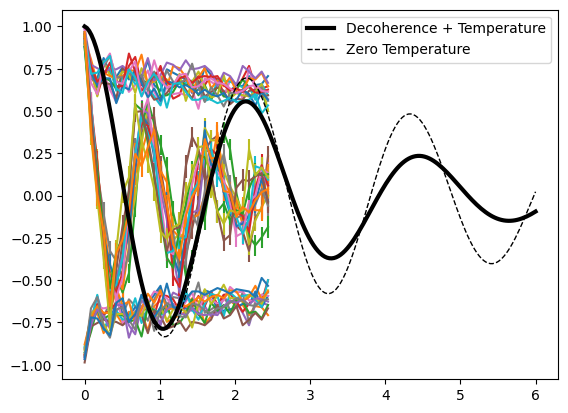

In [12]:
#print(res.x)
averaged = gen_full_results(theta_0, theta_dot, Omega)
for name_index in range(len(data_names)):
    plt.plot(times, 1-leakage_matrix[:,name_index])#, label = data_names[name_index])
    plt.plot(times, -1+leakage_matrix[:,name_index])#, label = data_names[name_index])
    plt.errorbar(times, flopping_matrix[:,name_index],  yerr = flopping_std_matrix[:,name_index]/np.sqrt(150))
plt.plot(integration_times*1e3, averaged, label="Decoherence + Temperature", lw=3, color='black', zorder=1000)
Omega = np.sqrt(230*2*np.pi)
averaged = gen_full_results(0, 0, Omega)
plt.plot(integration_times*1e3, averaged, label="Zero Temperature", lw=1, color='black', zorder=1000, linestyle='--')

plt.legend()


In [13]:
#optimize theta_0 and theta_dot to fit the data
def cost(params):
    theta_0, theta_dot, Omega = params
    averaged = gen_full_results(theta_0, theta_dot,Omega)
    return np.sum((averaged - y)**2)
#theta_0 = 0.1

from scipy.optimize import minimize
res = minimize(cost, [theta_0, theta_dot,Omega], method='Nelder-Mead')
print(res.x)



NameError: name 'y' is not defined

In [ ]:
from scipy.optimize import curve_fit

def exp(t, gamma, Omega, n, theta):
    return np.exp(-(gamma*t)**n)*1/(1 + (Omega*theta*t)**2)*np.cos(Omega/2/np.pi*t)
popt, pcov = curve_fit(exp, x, y, p0=[0, Omega/2/np.pi, 1, theta_0])
plt.scatter(x, y, label="Experimental")
plt.plot(integration_times*1e3, exp(integration_times*1e3, *popt), label="Fit")
print(popt)